## DSCI 100: GROUP PROJECT FINAL REPORT
 **Predicting Heart Disease in Hungary**
 > GROUP 10 - SECTION 007: Michelle Ho, Arian Afshari, Zidong Zhou, Kyle Wise

In [2]:
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
library(rsample)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
options(repr.matrix.max.rows = 6)
options(repr.plot.width=9, repr.plot.height=7)

### Introduction

**Background Information:**

> One of the leading causes of death in Hungary are cardiovascular diseases (CVDs) (OECD and WHO, 2017). It constitutes approximately 52.4% of the main diagnoses underlying cause of death and 47.6% of the secondary diagnoses prior to death. Heart failure is a common result of CVDs. Several risk factors are known to be associated with CVDs; the most prominent among them are high blood pressure, high cholesterol levels, and smoking (CDC, 2022). Moreover, susceptibility to heart disease increases with age and other uncontrollable factors such as sex (McLaren, 2023).

> As data science becomes progressively useful in analyzing and interpreting patient outcomes, we plan to use the k-nearest neighbors classification algorithm to predict angiographic disease status of CVDs. Our project will use the *Heart Disease* data set from the UCI Machine Learning Repository to build the model that will predict CVD diagnoses in presenting patients. The diagnosis of heart disease in the data set is defined as a binary label, whether the patient has the disease or not. The disease is present if there is greater than 50% diameter narrowing of any major blood vessels in a patient. Ie., if the value in the num parameter is 1, then more than 50% of the diameter of the major blood vessels are narrowing (Hungarian Institute of Cardiology, 1988). When blood vessels narrow, the heart does not receive the blood that it requries and thus, is considered heart disease.

> The dataset that we will be using features 14 attributes of patients that will be examined to determine which are possible indicators of heart disease:
> - Age
> - Sex
> - Chest pain type (cp); (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
> - Resting blood pressure (trestbps); (mmHg upon admission to hospital)
> - Serum cholestoral (chol); (mg/dl)
> - Fasting blood sugar (fbs) > 120 mg/dl; (1: true; 0: false)
> - Resting electrocardiographic results (restecg); (0: normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
> - Maximum heart rate achieved (thalach)
> - Exercise induced angina (exang); (1: yes; 0: no)
> - ST depression induced by exercise relative to rest (oldpeak)
> - Slope of the peak exercise ST segment (slope); (1: upsloping, 2: flat, 3: downsloping)
> - Number of major vessels (0-3) colored by flourosopy (ca)
> - Presence of heart defect (thal): (3: normal; 6: fixed defect; 7: reversable defect)
> - Diagnosis of heart disease (angiographic disease status) (num); (0: < 50% diameter narrowing, 1: > 50% diameter narrowing (the predicted attribute)

> To determine which of these variables are suitable for classifying angiographic disease status, we decided to implement correlation analysis. First, we performed one-hot encoding on our categorical variables to create new columns that contain numerical variables representing those categorical ones. Subsequently, the relationships of these variables with the target variable were then mapped into a correlation matrix. The variables with relatively high pearson correlation coefficients will be chosen as indicators to predict the presence of heart disease in patients.

**Preliminary data wrangling:**

The seed was set such that the numbers used in the analysis are reasonably random. It also permits reproducibility such that the same results are obtained each time this program is run.


In [4]:
set.seed(3789)

The Heart Disease data set from the UCI Machine Learning Repository was loaded and all of the observations containing "?" were converted to NA. String values of "?" are difficult to work with because the functions that are used in this program disregard NA values. Moreover, the variables were mutated to their correct type. Numerical variables were converted to doubles (dbl), and categorical variables were converted to factors (fct).

In [13]:
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak",
                                             "slope", "ca", "thal", "num"))
heart_disease_data[heart_disease_data == "?"]<-NA
heart_disease_data

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


*Table 1. Glimpse of the Original Heart Disease Data*

In [19]:
# using mutate_if, the character (chr) columns that are supposedly numerical were selected and mutated to dbl,
# mutate_at was then used to mutate the chr columns that are supposedly categorical to fct

heart_disease_data <- heart_disease_data |>
    mutate_if(is.character, as.numeric) |>
    mutate_at(vars("sex", "cp", "fbs", "restecg", "exang", "ca", "thal", "num", "slope"), factor)
heart_disease_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


*Table 2. Wrangled Heart Disease Data*

The wrangled *Heart Disease* data was then partitioned into training and testing sets with proportions of 75:25 respectively. To predict angiographic disease status, "num" has been selected as the class label. *Those that have a heart disease diagnoses will have a num value of 1, indicating that there is more than 50% blood vessels diameter narrowing. Those that do not have a heart disease diagnoses have a num value of 0, indicating that there is less than 50% blood vessels diameter narrowing.* The test data will be used in the exploratory data analysis to examine trends in the data and determine which variables are suitable as predictors. The test data is kept unused until the step of evaluating the model performance. This is to ensure that there is no positive bias when testing the accuracy of the model.

In [15]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

**Exploratory data analysis using training data:**

Exploratory data analysis was performed to investigate the data and summarize its main characteristics. The proportion of patients with a diagnosis of heart disease (positive angiographic disease status) and the proportion of patients without in the training data were identified in Table 3. The code to evaluate the original data was to ensure that the proportions were preserved during the split; the split was indeed preserved. Table 4 reports the number of rows that have missing data which is when there is at least one NA in the observation. This was important information to consider because several parts of the program will not run with NA values; mode imputation will be used to change all of the NAs in factors to their mode later in this program (methods section). Lastly, a summary of the training data is reported in Table 5 which includes the mean, minimum, and maximum of the numerical variables in the data.

In [16]:
heart_disease_data_proportions <- heart_disease_data |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_data))

heart_disease_train_proportions <- heart_disease_train |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_train))
heart_disease_train_proportions

diagnosis,people,percent
<fct>,<int>,<dbl>
0,141,64.09091
1,79,35.90909


*Table 3. Proportion of People with Heart Disease Diagnosis in the Training Data*

In [17]:
missing_data <- tibble(missing_data = nrow(heart_disease_train[!complete.cases(heart_disease_train),]))
missing_data

missing_data
<int>
220


*Table 4. Number of Rows with Missing Data (NA) in the Training Data*

In [18]:
heart_train_summary <- heart_disease_train |>
    summarise(across(c(age, trestbps, chol, thalach, oldpeak),
    list(mean = mean, min = min, max = max), na.rm = TRUE)) |>
    pivot_longer (everything(), names_to="variable", values_to="value") |>
    separate(variable, into = c("variable", "statistics"), sep = "_") |>
    pivot_wider(names_from = statistics, values_from = value)
heart_train_summary

variable,mean,min,max
<chr>,<dbl>,<dbl>,<dbl>
age,48.1090909,28,65
trestbps,132.3287671,92,180
chol,248.9365854,85,603
thalach,139.4155251,82,190
oldpeak,0.5877273,0,5


*Table 5. Summary of the Training Data: Mean, Minimum, Maximum*

### Methods

**Prediction variable selection:**

> 

Tidymodels was used to create a recipe using the training dataset. Step_dummy was used to generate one-encoded variables for factors with more than 2 levels that exist in the factor_cols vector. The recipe was then preped to do any necessary calculations. A new training dataset was made by applying the recipe to the original training dataset and all factors where changed into dbl in 2 steps to avoid an increase of 1 to all levels within the factors. The dbl columns are important for the next steps.

In [24]:
# factor_cols was used to change the target variable from factor -> character -> numerical prior to performing correlational analysis

# the factors had to be changed to character first because if the factors were changed directly to numerical, R automatically adds 1
# to every factor value (eg. if a factor, num, had the value of 0, it would turn to 1 after directly converting it to numerical)

# the solution that was found to solve this issue (to avoid levels increasing by 1) was to convert the factor to a character
# intermediate prior to changing it to a numerical

factor_cols = c("cp", "restecg", "thal", "slope")
fake_recipe <- recipe(num ~ ., data = heart_disease_train) |>
  step_dummy(factor_cols, one_hot = TRUE)

#Calculates changes
heart_prep <- fake_recipe |> prep()

#Applies changes and selects for the wanted columns. Mutates exang(Binary factor) to numeric.
heart_disease_train_dummy <- bake(heart_prep, heart_disease_train) |>
                                  mutate_if(is.factor, as.character) |>
                                  mutate_if(is.character, as.numeric)
glimpse(heart_disease_train_dummy)

Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”


Rows: 220
Columns: 23
$ age        <dbl> 28, 29, 30, 31, 32, 33, 34, 34, 34, 35, 35, 35, 35, 36, 36,…
$ sex        <dbl> 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,…
$ trestbps   <dbl> 130, 140, 170, 100, 125, 120, 130, 150, 98, 120, 140, 120, …
$ chol       <dbl> 132, NA, 237, 219, 254, 298, 161, 214, 220, 160, 167, 308, …
$ fbs        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ thalach    <dbl> 185, 170, 170, 150, 155, 185, 190, 168, 150, 185, 150, 180,…
$ exang      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ oldpeak    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,…
$ ca         <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ num        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X1      <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X2      <dbl> 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X3      <dbl>

*Table 6. One-Hot Encoding Training Data*

In [25]:
# creating a correlational matrix of heart_disease_train_dummy, neglecting NAs
corr_matrix <- cor(heart_disease_train_dummy, use = "pairwise.complete.obs")

# converting the matrix into a data frame
corr_df <- as.data.frame(corr_matrix)

# the relationship between num and all other variables
num_corrs <- corr_df["num"]
num_corrs <- num_corrs |>
    arrange(desc(abs(num_corrs)))
print(num_corrs)

# In a binary factor, there are only two possible levels, which are opposite of each other. For example, in the "sex" variable,
# the levels could be "male" and "female." If a person is not male, then we know they must be female. Therefore, to determine 
# the status of a binary factor, we only need to look at one level of that factor. By the same logic, we can ignore the
# dummy variables with opposite signs and directly use those binary factors as predictors by converting them into numerical.

Warning message in cor(heart_disease_train_dummy, use = "pairwise.complete.obs"):
“the standard deviation is zero”


                    num
num         1.000000000
exang       0.604936038
slope_X1   -0.592220092
slope_X2    0.547559811
cp_X4       0.537148449
thal_X3    -0.521050106
oldpeak     0.506800915
cp_X2      -0.426868985
thalach    -0.323469233
thal_X7     0.292307692
sex         0.219885071
chol        0.205718495
age         0.200172592
fbs         0.193377587
thal_X6     0.182323225
trestbps    0.161365988
cp_X3      -0.151870181
slope_X3    0.075853411
restecg_X2 -0.066416665
restecg_X1  0.025215449
cp_X1      -0.011088801
restecg_X0  0.002210262
ca                   NA


*Table 7. Correlation Matrix*

Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message in cor(predictor_train, use = "pairwise.complete.obs"):
“the standard deviation is zero”


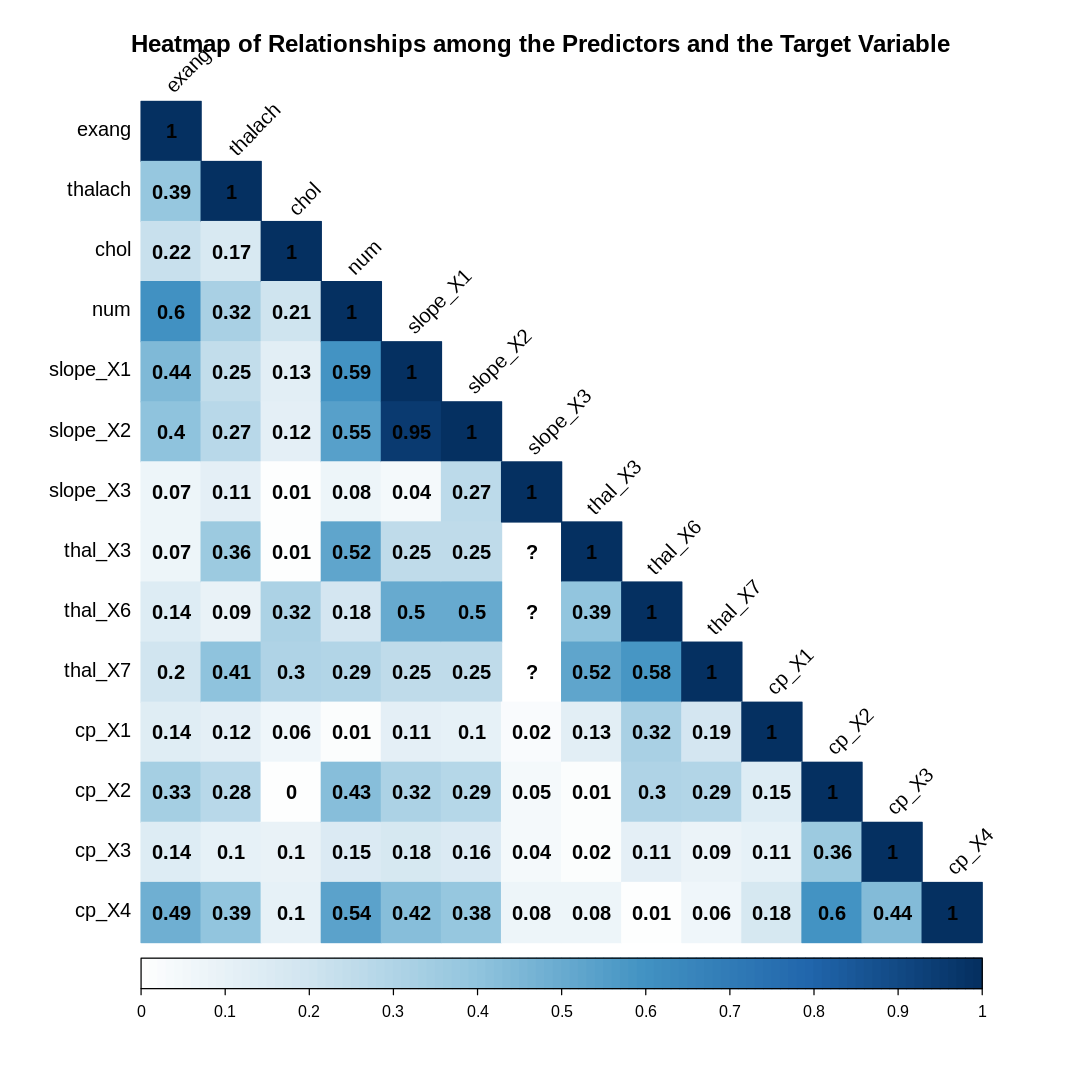

In [28]:
p_cols <- c("slope", "thal", "cp")
predictors <- c("num", "exang", "slope", "thal", "cp", "thalach", "chol")

selected_predictor_train <- heart_disease_train |> select(all_of(predictors))
p_recipe <- recipe(num ~ ., data = selected_predictor_train) |>
  step_dummy(p_cols, one_hot = TRUE)

#Calculates changes
heart_prep <- p_recipe |> prep()

#Applies changes and selects for the wanted columns. Mutates exang(Binary factor) to numeric.
predictor_train <- bake(heart_prep, selected_predictor_train) |> mutate_if(is.factor, as.character) |>
                   mutate_if(is.character, as.numeric)

# heatmap of the new dataframe

# calculating the correlation matrix, ignoring NAs and applying abolute value to it
corr_matrix <- cor(predictor_train, use = "pairwise.complete.obs") |>
                   abs()

options(repr.plot.width=9, repr.plot.height=9)

# plotting heatmap from the correlatinal matrix (situated in the lower half, legend limit starts from 0 to 1 since abs value was
# applied, squares colored based on correlation strength, texts are in black, diagonal names are angled at 45 degrees and the R
# values are displayed in black.
corrplot(corr_matrix, type = "lower",col.lim = c(0, 1), method = "color", 
         tl.col = "black", tl.srt =45, addCoef.col = "black", 
         title = "\n\n\nHeatmap of Relationships among the Predictors and the Target Variable")
# the greater the color intensity and value, the greater the correlation

*Figure 1. Heatmap of Relationships among the Predictors and the Target Variable*

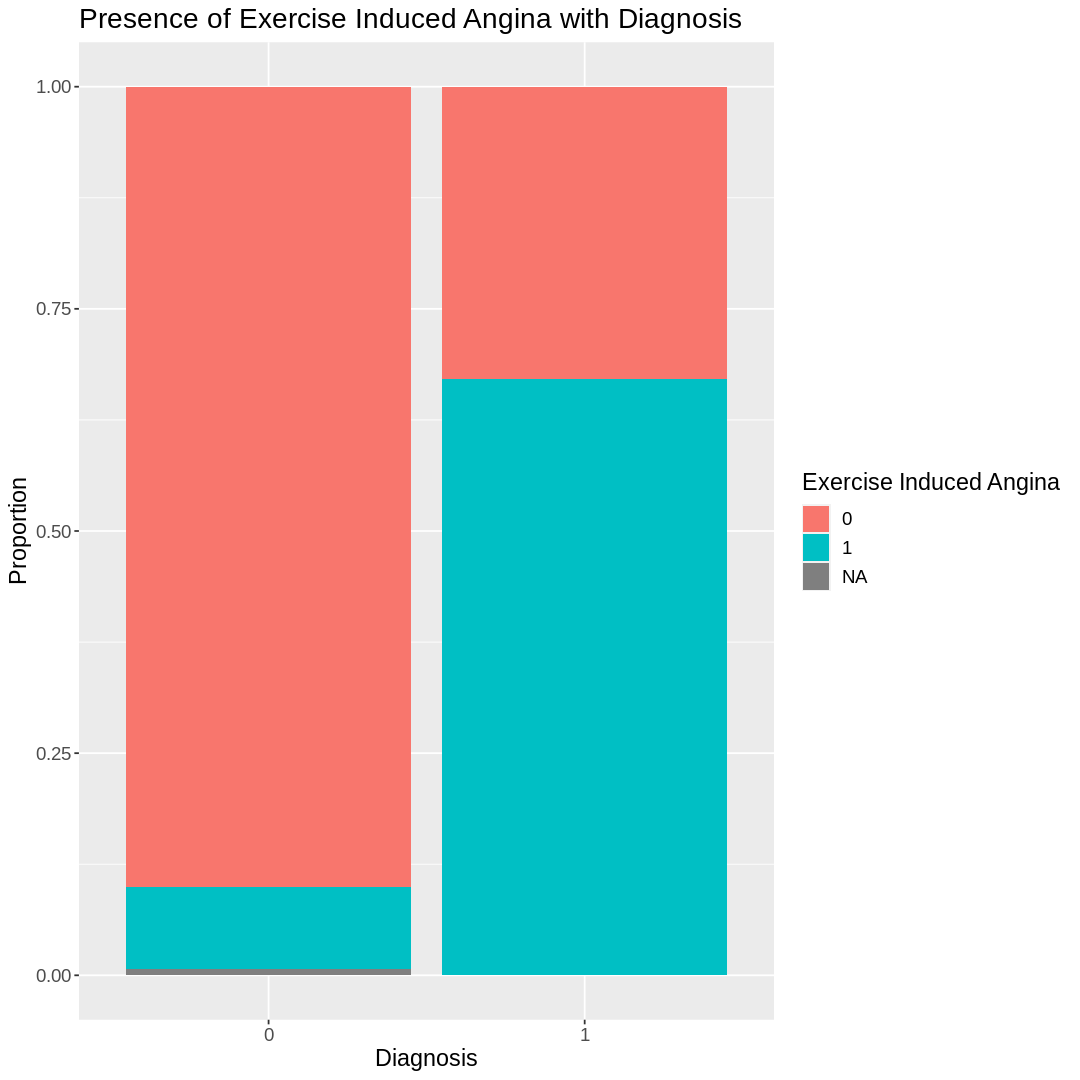

In [81]:
# bar plot of diganosis vs exang (the best predictor)
ggplot(predictor_train, aes(x = as.factor(num), fill = as.factor(exang))) +
    geom_bar(position = "fill") +
    labs(x = "Diagnosis", y = "Proportion", 
    title = "Presence of Exercise Induced Angina with Diagnosis",
    fill = "Exercise Induced Angina") +
    theme(text = element_text(size = 14))

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


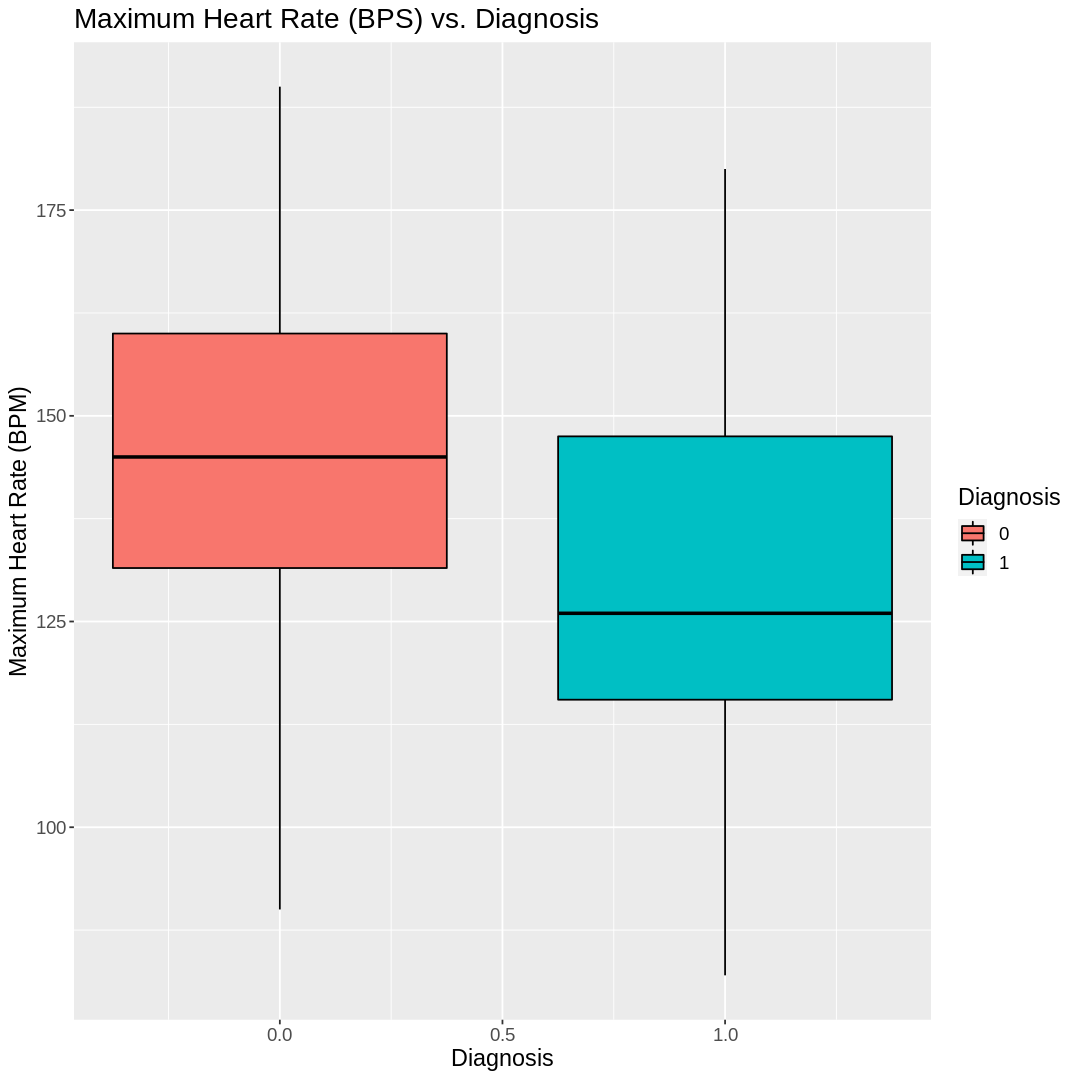

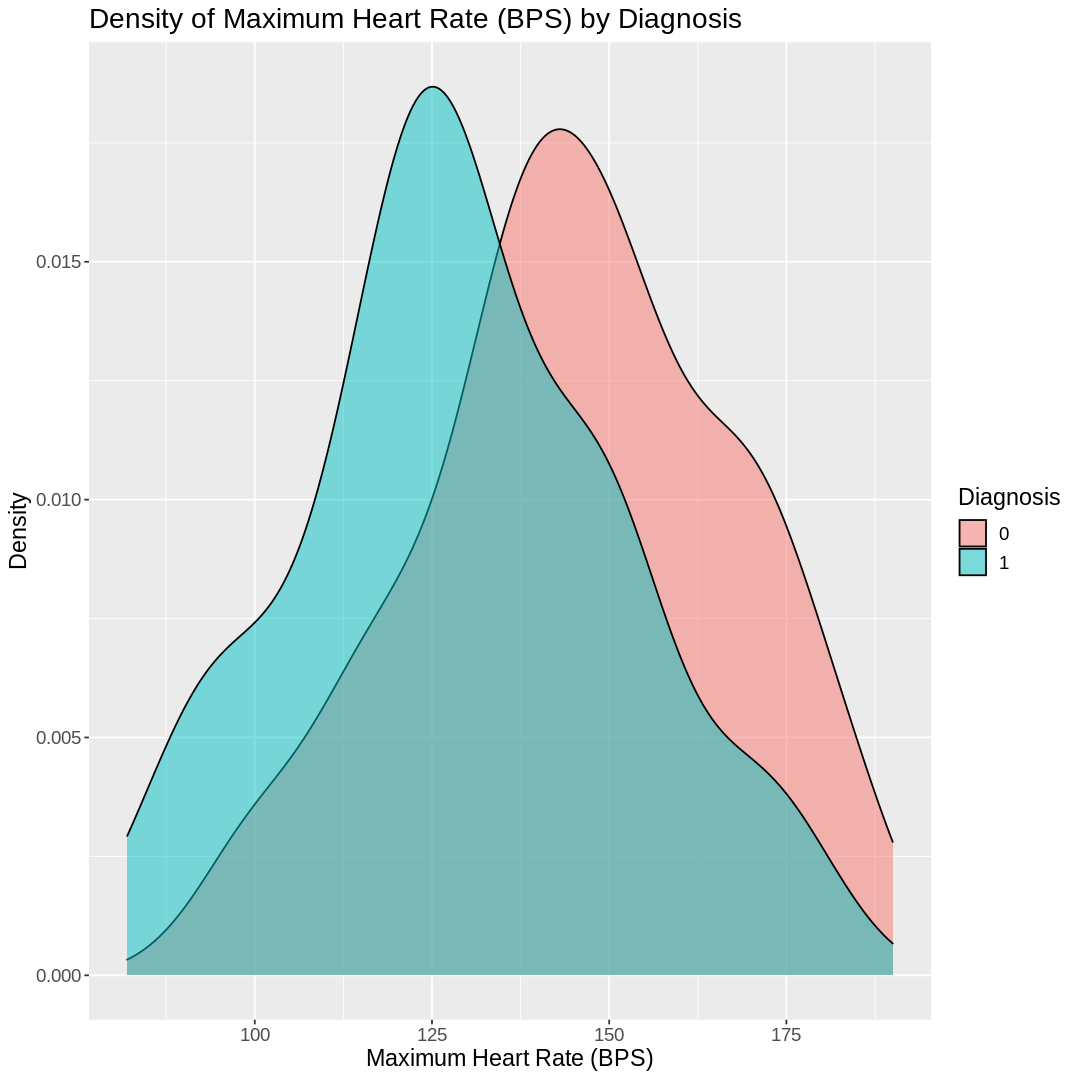

In [82]:
# box plot of of the predictor variable maximum heart rate (BPS) (the strongest numerical predictor) and diagnosis
ggplot(predictor_train, aes(x = num, y = thalach, fill = factor(num))) +
    geom_boxplot(color = "black") +
    labs(x = "Diagnosis", y = "Maximum Heart Rate (BPM)", 
         title = "Maximum Heart Rate (BPS) vs. Diagnosis",
         fill = "Diagnosis") +
    theme(text = element_text(size = 14)) +
    guides(fill = guide_legend(title = "Diagnosis"))


# density plot of of the predictor variable maximum heart rate (BPS) and diagnosis
ggplot(predictor_train, aes(x = thalach, fill = factor(num))) +
    geom_density(alpha = 0.5) +
    labs(x = "Maximum Heart Rate (BPS)", y = "Density", 
    title = "Density of Maximum Heart Rate (BPS) by Diagnosis",
    fill = "Diagnosis") +
    theme(text = element_text(size = 14))

Warning message:
“Removed 15 rows containing non-finite values (stat_density).”


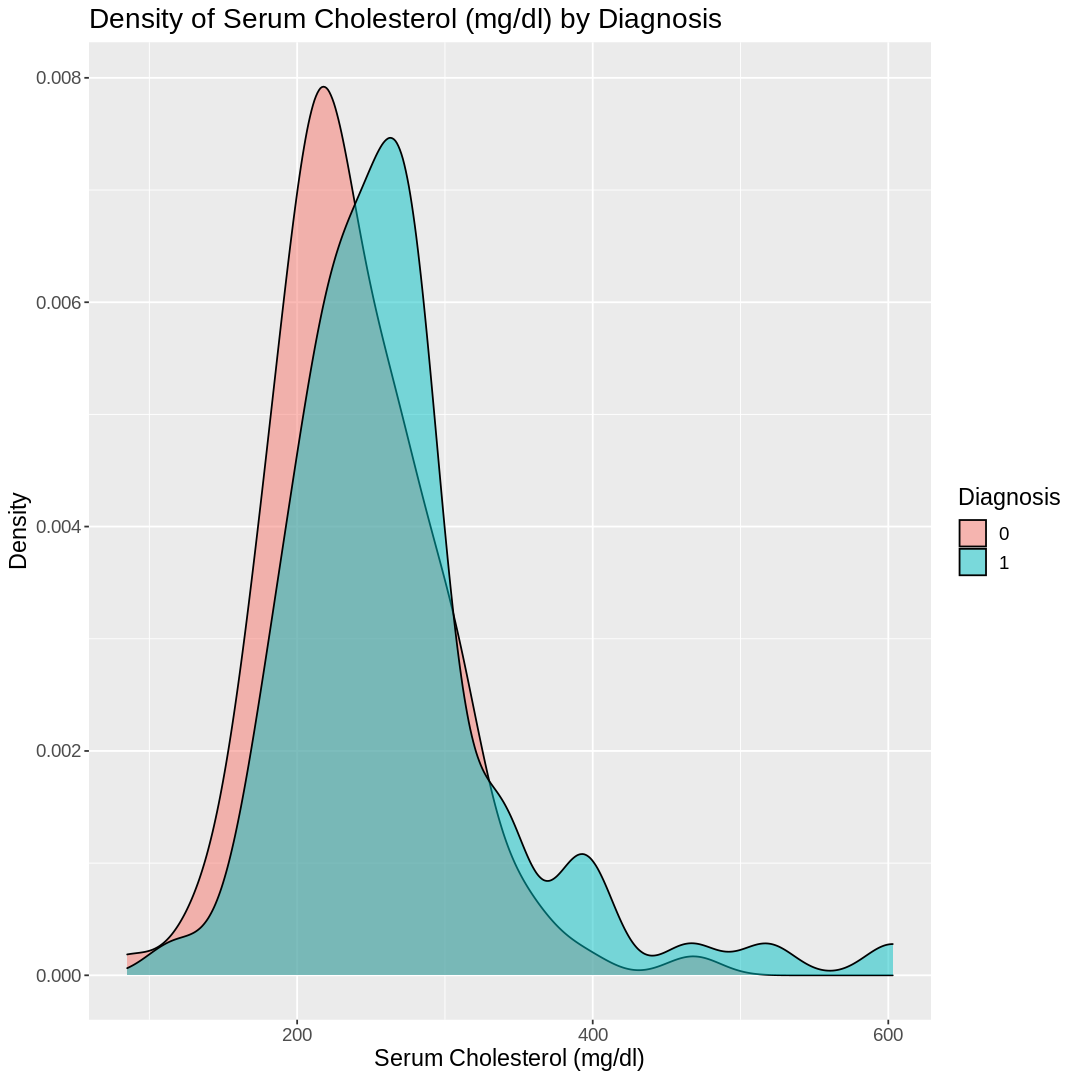

In [83]:
# density plot of of the predictor variable serum cholesterol (mg/dl) and diagnosis
ggplot(predictor_train, aes(x = chol, fill = factor(num))) +
    geom_density(alpha = 0.5) +
    labs(x = "Serum Cholesterol (mg/dl)", y = "Density", 
    title = "Density of Serum Cholesterol (mg/dl) by Diagnosis",
    fill = "Diagnosis") +
    theme(text = element_text(size = 14))

**Developing the classification algorithm:**

In [84]:
#Vector of factor coloumns that have >2 levels
factor_cols <- c("slope", "thal", "cp")
#Predictors + target variable
useful <- c("num", "exang", "slope_X1", "slope_X2", "cp_X4", "thal_X3", "chol", "thalach")

#Recipe that creates dummies for all objects in factor cols
heart_pre_recipe <- recipe(num ~ ., data = heart_disease_train) |>
  step_dummy(factor_cols, one_hot = TRUE)

#Calculates changes
heart_prep <- heart_pre_recipe |> prep()

#Applies changes and selects for the wanted columns. Mutates exang(Binary factor) to numeric.
heart_train_processed <- bake(heart_prep, heart_disease_train) |> select(useful) |> mutate(exang=as.numeric(exang))
heart_test_processed <- bake(heart_prep, heart_disease_test) |> select(useful) |> mutate(exang=as.numeric(exang))

heart_recipe <- recipe(num ~ ., data = heart_train_processed) |>
  step_scale(chol, thalach) |>
  step_center(chol, thalach)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification") 

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 2))
heart_vfold <- vfold_cv(heart_train_processed, v = 5, strata = num)

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
x Fold1: preprocessor 1/1, model 1/1: Error in `[.default`(cl, C): only 0's may be mixed with negative subscripts

x Fold2: preprocessor 1/1, model 1/1: Error in `[.default`(cl, C): only 0's may be mixed with negative subscripts

x Fold3: preprocessor 1/1, model 1/1: Error in `[.default`(cl, C): only 0's may be mixed with negative subscripts

x Fold4: preprocessor 1/1, model 1/1: Error in `[.default`(cl, C): only 0's may be mixed with negative subscripts

x Fold5: preprocessor 1/1, model 1/1: Error in `[.default`(cl, C): only 0's may be mixed with negative subscripts

Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more informa

ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


### Results

**Data analysis:**

**Visualization of outcomes:**

### References

CDC: Centers for Disease Control and Prevention. (2022). Heart Disease and Stroke.
https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity.

Hungarian Institute of Cardiology. (1988). Heart Disease Data Set [Dataset]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

McLaren. (2023). Heart Disease. 
https://www.mclaren.org/main/heart-disease-risk-factors#:~:text=The%20%22uncontrollable%22%20risk%20factors%20are,and%20common%20lifestyles%20increase%20risk)

OECD and World Health Organization (WHO). (2021). State of health in the EU: Country Health Profile 
2017 - Hungary. https://www.euro.who.int/__data/assets/pdf_file/0006/355983/Health-Profile-Hungary-Eng.pdf